# Setup and data loading

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Data
Here we load data from tensorflow_datasets (hereafter TFDS). Stanford Dogs dataset is provided in TFDS as stanford_dogs. It features 20,580 images that belong to 120 classes of dog breeds (12,000 for training and 8,580 for testing).

In [2]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], 
    with_info=True, 
    as_supervised=True
)

NUM_CLASSES = ds_info.features["label"].num_classes

# Resizing the images
When the dataset include images with various size, we need to resize them into a shared size. The Stanford Dogs dataset includes only images at least 200x200 pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image,size),label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

# Visualizing the data
The following code shows the first 9 images with their labels.

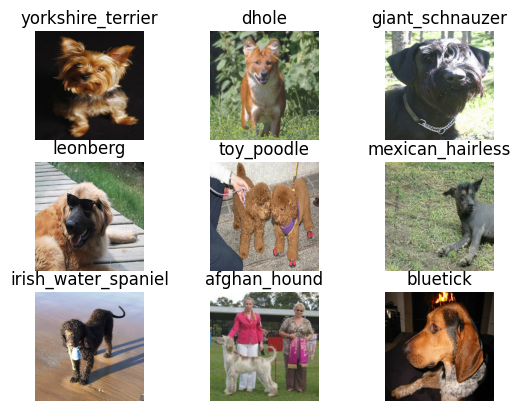

In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image,label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

# Data augmentation
We can use the preprocessing layers APIs for image augmentation.

In [5]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

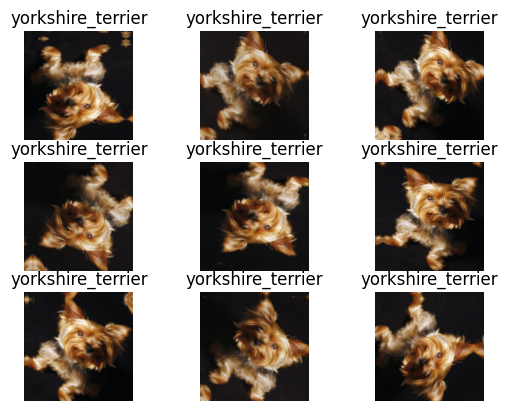

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [7]:
# Display dataset information
print(ds_info)

for image, label in ds_train.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around the
    world. This dataset has been built using images and annotation from ImageNet for
    the task of fine-grained image categorization. There are 20,580 images, out of
    which 12,000 are used for training and 8580 for testing. Class labels and
    bounding box annotations are provided for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/root/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
        'objects': Sequence({
            'bbox': 

# Prepare inputs

In [8]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image,label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

# Training the model from scratch

In [9]:
model = EfficientNetB0(
    include_top = True,
    weights = None,
    classes = NUM_CLASSES,
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
)
model.compile(
    optimizer="adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

epochs = 40
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization[0

2023-12-12 16:29:01.511697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 [==============================] - 188s 785ms/step - loss: 4.9902 - accuracy: 0.0103 - val_loss: 5.3067 - val_accuracy: 0.0058
Epoch 2/40
187/187 [==============================] - 148s 789ms/step - loss: 4.6804 - accuracy: 0.0181 - val_loss: 4.8011 - val_accuracy: 0.0121
Epoch 3/40
187/187 [==============================] - 147s 788ms/step - loss: 4.4854 - accuracy: 0.0306 - val_loss: 4.6152 - val_accuracy: 0.0322
Epoch 4/40
187/187 [==============================] - 147s 788ms/step - loss: 4.3361 - accuracy: 0.0420 - val_loss: 5.0838 - val_accuracy: 0.0290
Epoch 5/40
187/187 [==============================] - 147s 788ms/step - loss: 4.2251 - accuracy: 0.0496 - val_loss: 4.3931 - val_accuracy: 0.0434
Epoch 6/40
187/187 [==============================] - 148s 792ms/step - loss: 4.1284 - accuracy: 0.0601 - val_loss: 4.3782 - val_accuracy: 0.0382
Epoch 7/40
187/187 [==============================] - 148s 790ms/step - loss: 4.0504 - accuracy: 0.0701 - val_loss: 4.4688 - val_accura

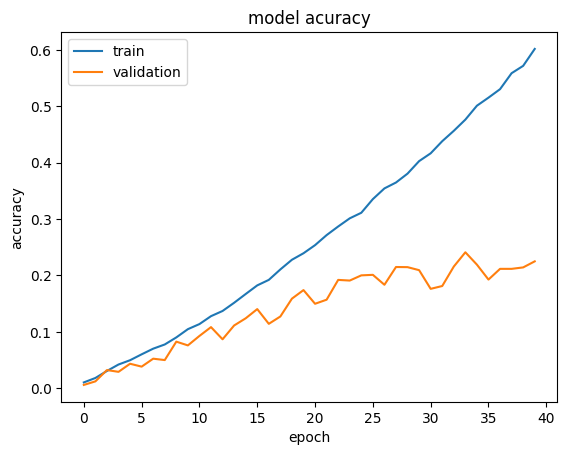

In [11]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model acuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    

plot_hist(hist)    

# Transfer learning from pre-trained weights
Here we initialize the model with pre-trained ImageNet weights, and we fine-tune it on our own dataset.

In [13]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/25


2023-12-12 19:33:18.178888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 [==============================] - 88s 433ms/step - loss: 3.2865 - accuracy: 0.4239 - val_loss: 0.8586 - val_accuracy: 0.7402
Epoch 2/25
187/187 [==============================] - 85s 457ms/step - loss: 1.6485 - accuracy: 0.5807 - val_loss: 0.7010 - val_accuracy: 0.7850
Epoch 3/25
187/187 [==============================] - 80s 428ms/step - loss: 1.3548 - accuracy: 0.6234 - val_loss: 0.6895 - val_accuracy: 0.7902
Epoch 4/25
187/187 [==============================] - 80s 427ms/step - loss: 1.2427 - accuracy: 0.6468 - val_loss: 0.6816 - val_accuracy: 0.7950
Epoch 5/25
187/187 [==============================] - 80s 428ms/step - loss: 1.1874 - accuracy: 0.6639 - val_loss: 0.6957 - val_accuracy: 0.7942
Epoch 6/25
187/187 [==============================] - 80s 429ms/step - loss: 1.1525 - accuracy: 0.6710 - val_loss: 0.6980 - val_accuracy: 0.7944
Epoch 7/25
187/187 [==============================] - 80s 427ms/step - loss: 1.1369 - accuracy: 0.6745 - val_loss: 0.6873 - val_accuracy: 0.7

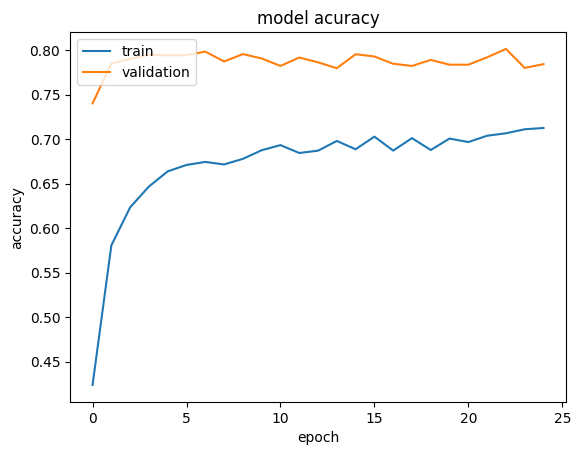

In [15]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Epoch 1/4


2023-12-12 20:18:06.464100: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 [==============================] - 89s 436ms/step - loss: 0.7547 - accuracy: 0.7757 - val_loss: 0.6974 - val_accuracy: 0.8130
Epoch 2/4
187/187 [==============================] - 81s 432ms/step - loss: 0.7482 - accuracy: 0.7742 - val_loss: 0.6937 - val_accuracy: 0.8147
Epoch 3/4
187/187 [==============================] - 81s 434ms/step - loss: 0.7346 - accuracy: 0.7784 - val_loss: 0.6899 - val_accuracy: 0.8154
Epoch 4/4
187/187 [==============================] - 81s 433ms/step - loss: 0.7144 - accuracy: 0.7830 - val_loss: 0.6893 - val_accuracy: 0.8167


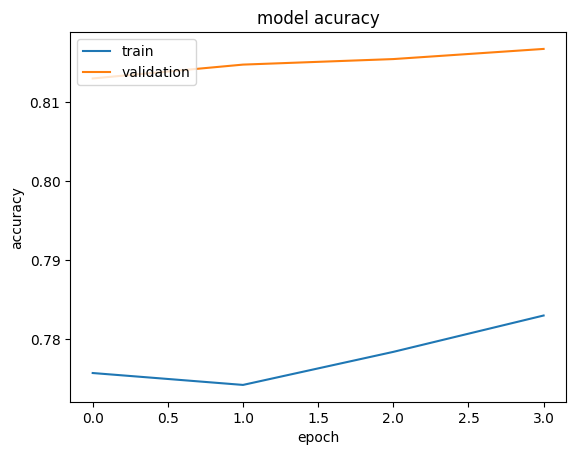

In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
           
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

epochs = 4
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)